In [1]:
import numpy as np
from itertools import product
from scipy.special import comb
from tqdm.auto import tqdm
from scipy.stats import entropy
import seaborn as sns
import matplotlib.pyplot as plt
from more_itertools import set_partitions

# Figure 2: $\ \ \mathcal{I}_\text{EBIM}(p_X, R)$ vs. $R$ 

In [2]:
# set the input distribution

'''note that the brute force search for alphabet size of more than 3 may take a
very longe time'''

P_x = np.array([.1, .2, .7]) 

### Brute Force Search for EBIM

In [3]:
# grid search join distributions 

def generate_matrices(N, batch_size=100):
    # Generate all possible combinations for a single column where the sum is 1
    valid_columns = []
    for a in range(0, N + 1):
        for b in range(0, N + 1 - a):
            c = N - a - b
            assert a + b + c == N
            valid_columns.append([a / N, b / N, c / N])

    # Use product to generate all possible 3x3 matrices
    all_combinations = product(valid_columns, repeat=3)
    batch = []

    for cols in all_combinations:
        matrix = np.column_stack(cols)
        batch.append(matrix)
        if len(batch) == batch_size:
            yield batch
            batch = []
    
    # Yield any remaining matrices if they don't fill a complete batch
    if batch:
        yield batch


def total_matrices(N):
    valid_columns = comb(N+2, 2, exact=True)
    return valid_columns ** 3

# Example usage
N = 10
real_total_matrices = sum(len(a) for a in generate_matrices(N, batch_size=100))

print("Estimate number of 3x3 matrices for N =", N, "is:", total_matrices(N))
print("Total number of 3x3 matrices for N =", N, "is:", real_total_matrices)


Estimate number of 3x3 matrices for N = 10 is: 287496
Total number of 3x3 matrices for N = 10 is: 287496


In [4]:
# brute force calculation of I and H_t for all joint distributions

P_x.sort()
I, H_t = [], []

h = entropy

N, batch_size = 20, 1000
for P_tx in tqdm(generate_matrices(N, batch_size), total=total_matrices(N)/batch_size):
    H_t_ = h(P_tx @ P_x, axis=1)
    H_tx_ = h(P_tx, axis=1) @ P_x
    I_ = H_t_ - H_tx_
    
    I.append(I_)
    H_t.append(H_t_)

I = np.concatenate(I)
H_t = np.concatenate(H_t)

  0%|          | 0/12326.391 [00:00<?, ?it/s]

In [5]:
# for each R, find the highest I

R_values = np.linspace(0, h(P_x), 1000)
new_R_values = []

best_idx = []
for R in tqdm(R_values):
    
    idx = H_t <= R 
    idx = idx & (I == I[idx].max()) # maximum I that H_t <= R 
    idx = idx.nonzero()[0]
    idx = idx[H_t[idx].argmin()] # among them the one with the highest H
    
    if len(best_idx) == 0 or I[idx] - I[best_idx[-1]] > 1e-4:
        best_idx.append(idx)
        new_R_values.append(R)
    
best_idx = np.array(best_idx)
R_values = new_R_values

  0%|          | 0/1000 [00:00<?, ?it/s]

## Theorem 3 for EBIM

In [6]:
def move_mass(x, t1, t2, P_xt):
    # add zero col to P_xt
    zero_col = np.zeros((P_xt.shape[0], 1))
    P_xt = np.concatenate((P_xt, zero_col), axis=1)
    
    a = np.linspace(0, P_xt[x, t1], 50)
    diff = np.zeros((len(a), *P_xt.shape))
    diff[:, x, t1] = -a
    diff[:, x, t2] = a
    P_xt = P_xt + diff

    P_t = P_xt.sum(axis=1)
    H_t = h(P_t, axis=-1)
    H_tx = h(P_xt.reshape(P_xt.shape[0], -1), axis=-1)
    I_tx = h(P_x) + H_t - H_tx
    
    idx = np.argsort(H_t)
    return H_t[idx], I_tx[idx]

def iter_deterministic_mappings(P_x):
    for partition in set_partitions(P_x):
        det_mapping = np.zeros((len(P_x), len(partition)))
        x = 0
        for t, p in enumerate(partition):
            det_mapping[x:x+len(p), t] = p
            x += len(p)
        yield det_mapping

def nonzero_amin(P_xt):
    P_xt[P_xt > 0]
    masked = np.where(P_xt > 0, P_xt, np.inf)
    return np.argmin(masked)

def neighborhood_algo(P_x):
    for det_mapping in iter_deterministic_mappings(P_x):
        # print(det_mapping)
        #1
        col_normalized = det_mapping / det_mapping.sum(0, keepdims=True)
        x, t1 = np.unravel_index(nonzero_amin(col_normalized), col_normalized.shape)
        t2 = det_mapping.shape[1]
        # print(f'{x=}, {t1=}, {t2=}')
        H_t1, I_tx1 = move_mass(x, t1, t2, det_mapping)
        
        #2
        P_t = det_mapping.sum(0)
        t1 = nonzero_amin(P_t)
        x = nonzero_amin(det_mapping[:, t1])
        t2 = np.argmax(P_t)
        # print(f'{x=}, {t1=}, {t2=}')
        H_t2, I_tx2 = move_mass(x, t1, t2, det_mapping)
        
        yield (H_t1, I_tx1), (H_t2, I_tx2)
        

def merge_segments(segments, num_points=1000):
    # Find the minimum and maximum x-values across all segments
    min_x = min(min(segment[0]) for segment in segments)
    max_x = max(max(segment[0]) for segment in segments)

    # Create a linspace grid from the min to max x-value
    x_grid = np.linspace(min_x, max_x, num_points)

    # Evaluate each segment's y-values on the x_grid using interpolation
    ys = []
    for x, y in segments:
        # Interpolate y-values at grid points
        idx = np.argsort(x)
        interpolated_y = np.interp(x_grid, x[idx], y[idx], left=-np.inf, right=-np.inf)
        ys.append(interpolated_y)
    ys = np.vstack(ys)
    return x_grid, ys.max(axis=0)
        

### Plot

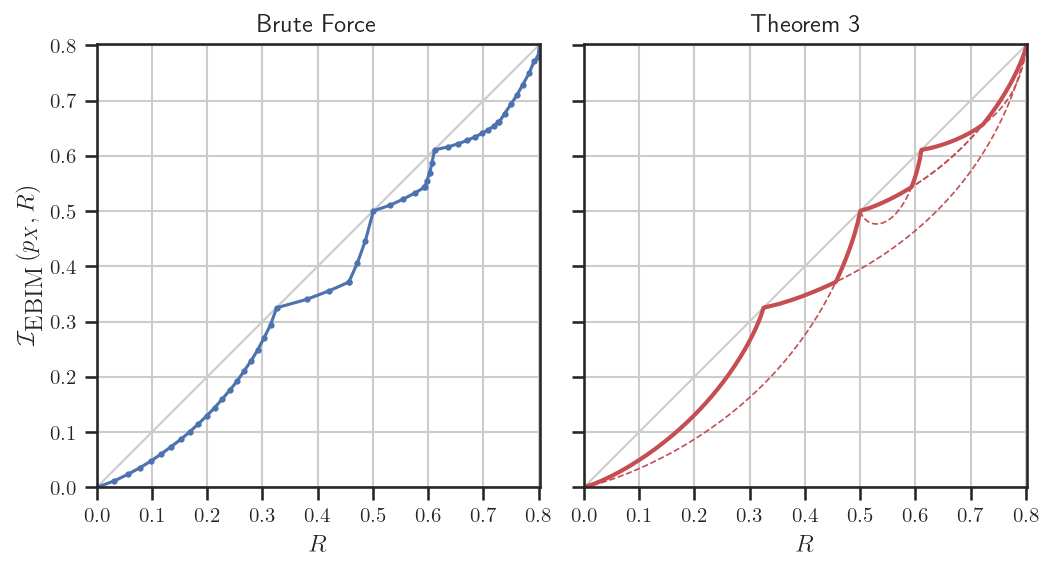

In [7]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("notebook")
plt.rcParams['text.usetex'] = True

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150, sharey=True, gridspec_kw = {'wspace':.1})

px_ent = h(P_x)
ticks = np.arange(0, px_ent, .1)
for ax in axs.flat:
       ax.set(xlim=(0, px_ent), ylim=(0, px_ent), xlabel=r'$R$',
              xticks=ticks, yticks=ticks)
       ax.grid()
       ax.set_aspect('equal', adjustable='box')
       gridcolor = ax.get_xgridlines()[0].get_color()
       ax.plot([0, 1], [0, 1], '-', c=gridcolor, lw=1)
       
       for label in ax.get_xticklabels() + ax.get_yticklabels():
              label.set_fontsize(10)

axs[0].set_ylabel(r'$\mathcal{I}_\textrm{EBIM} \, (p_X, R)$')
axs[0].set_title('Brute Force')
axs[1].set_title('Theorem 3')

# get curve segments from neighborhood_algo
curves = []
for c in neighborhood_algo(P_x):
       curves += c
       
# plot brute force
axs[0].plot(R_values, I[best_idx], 'b.-', ms=4)

# plot segments
for H_t, I_tx in curves:
       axs[1].plot(H_t, I_tx, 'r--', ms=1, lw=.8)

# plot largest peices
R_hat, I_hat = merge_segments(curves, num_points=1000)
axs[1].plot(R_hat, I_hat, 'r', ms=.1, lw=2)